<a href="https://colab.research.google.com/github/lucienrivat/PommePOire/blob/main/PommePoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dossier des images Apple : /content/datasets/apple
Dossier des images Pear : /content/datasets/pear
Chemin absolu Apple : /content/datasets/apple
Chemin absolu Pear : /content/datasets/pear
Contenu du dossier Apple : [PosixPath('/content/datasets/apple/Apple Red 1'), PosixPath('/content/datasets/apple/Apple Red Yellow 1'), PosixPath('/content/datasets/apple/Apple Red 2'), PosixPath('/content/datasets/apple/Apple Red Delicious 1'), PosixPath('/content/datasets/apple/Apple Red 3'), PosixPath('/content/datasets/apple/Apple Red Yellow 2')]
Nombre d'images Apple trouvées : 3067
Nombre d'images Pear trouvées : 5252
Found 8319 files belonging to 2 classes.
Using 6656 files for training.
Found 8319 files belonging to 2 classes.
Using 1663 files for validation.


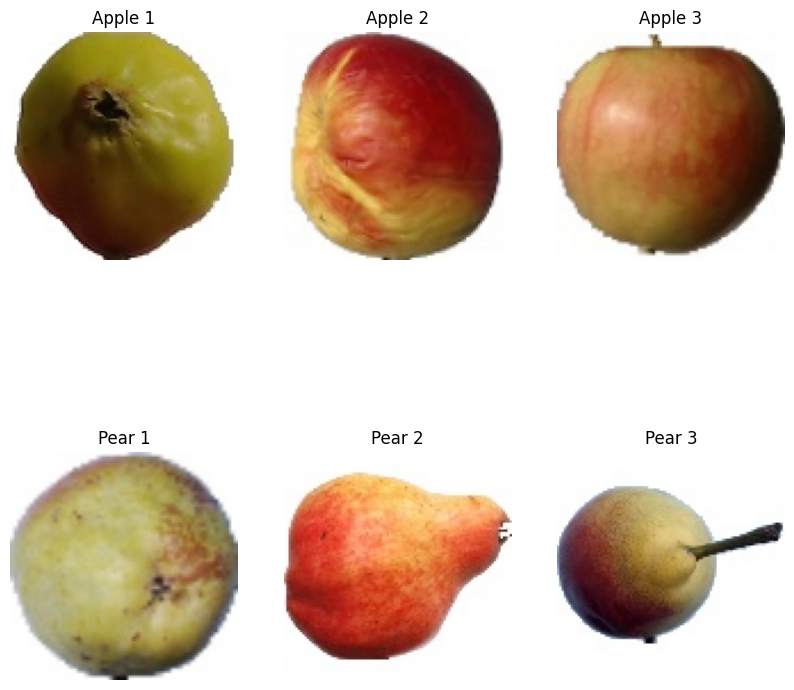

In [14]:
# Import dataset
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
import random

# Télécharger le fichier ZIP Apple depuis GitHub
apple_zip = tf.keras.utils.get_file(
    "Apple.zip",
    "https://github.com/lucienrivat/PommePOire/raw/main/apple.zip",
    extract=False
)

# Télécharger le fichier ZIP Pear depuis GitHub
pear_zip = tf.keras.utils.get_file(
    "Pear.zip",
    "https://github.com/lucienrivat/PommePOire/raw/main/pear.zip",
    extract=False
)

# Extraire les fichiers ZIP dans /content/datasets
with zipfile.ZipFile(apple_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')

with zipfile.ZipFile(pear_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/')

# Définir les chemins des dossiers contenant les images
apple_data_dir = pathlib.Path('/content/datasets/apple/')
pear_data_dir = pathlib.Path('/content/datasets/pear/')

print("Dossier des images Apple :", apple_data_dir)
print("Dossier des images Pear :", pear_data_dir)
print("Chemin absolu Apple :", os.path.abspath(apple_data_dir))
print("Chemin absolu Pear :", os.path.abspath(pear_data_dir))

# Vérifier les fichiers dans le dossier Apple
print(f"Contenu du dossier Apple : {list(apple_data_dir.glob('*'))}")

# Compter le nombre d'images dans chaque dataset
apple_image_count = len(list(apple_data_dir.glob('*/*')))  # Cherche dans tous les sous-dossiers aussi
pear_image_count = sum([len(list(pear_data_dir.glob(f'{folder}/*'))) for folder in os.listdir(pear_data_dir)])

print("Nombre d'images Apple trouvées :", apple_image_count)
print("Nombre d'images Pear trouvées :", pear_image_count)

# Définir les paramètres du dataset
batch_size = 3
img_height = 200
img_width = 200

data_dir = pathlib.Path('/content/datasets/')

# Charger les datasets Apple
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)


# Afficher des images aléatoires d'Apple et Pear
plt.figure(figsize=(10, 10))
images_to_display = []

# Sélectionner 3 images aléatoires d'Apple
for _ in range(3):
    apple_image = random.choice(list(apple_data_dir.glob('*/*.jpg')))
    img_apple = mpimg.imread(apple_image)
    images_to_display.append(img_apple)

# Sélectionner 3 images aléatoires de Pear (à partir de sous-dossiers)
pear_subfolders = [folder for folder in os.listdir(pear_data_dir) if os.path.isdir(os.path.join(pear_data_dir, folder))]

for _ in range(3):
    chosen_pear_folder = random.choice(pear_subfolders)
    pear_images = list(pathlib.Path(pear_data_dir, chosen_pear_folder).glob('*.*'))
    random_pear_image = random.choice(pear_images)
    img_pear = mpimg.imread(random_pear_image)
    images_to_display.append(img_pear)

# Afficher les images sélectionnées
for i, img in enumerate(images_to_display):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    if i < 3:
        plt.title(f"Apple {i + 1}")
    else:
        plt.title(f"Pear {i - 2}")
plt.show()


In [ ]:
from tensorflow.keras import layers

num_classes = 2

model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_images=True
)


model.fit(
    train_data,
  validation_data=val_data,
  epochs=2,
  callbacks=[tensorboard_callback]
)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1523/1523 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9344 - loss: 0.1815 - val_accuracy: 0.9623 - val_loss: 0.1353
Epoch 2/2
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9853 - loss: 0.0425 - val_accuracy: 0.9991 - val_loss: 0.0029


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 197, 197, 128)       │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 95, 95, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 47, 47, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 32)          │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 16)          │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1296)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          83,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 784,664 (2.99 MB)

 Trainable params: 261,554 (1021.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 523,110 (2.00 MB)

Saving shutterstock_102978833.jpg to shutterstock_102978833.jpg


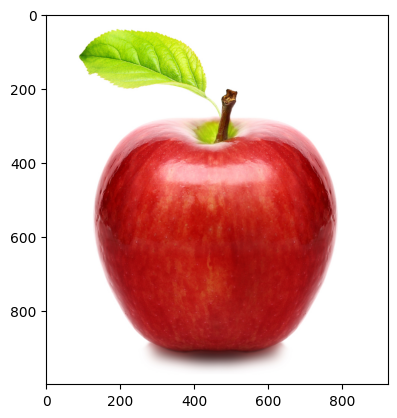

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Prediction : [[0. 1.]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
from google.colab import files
import cv2
import numpy as np
import pathlib
import random
import matplotlib.pyplot as plt
import os

# Fonction pour charger et prédire une image
def predict_image(image_path):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    img_to_predict = np.expand_dims(cv2.resize(image, (200, 200)), axis=0)
    res = model.predict(img_to_predict)
    return res

# Demander à l'utilisateur de télécharger une image depuis son PC
file_to_predict = files.upload()

# Traiter chaque fichier téléchargé
for file_ in file_to_predict:
    # Charger l'image
    image_path = file_

    # Prédiction et affichage
    res = predict_image(image_path)

    # Afficher le résultat
    print(f"Prediction : {res}")

    # Déterminer si c'est une pomme ou une poire selon la prédiction
    if res == 1:  # Supposons que 1 soit pour la poire et 0 pour la pomme
        print("C'est une poire !")
    elif res == 0:
        print("C'est une pomme !")
